# Descarga de datos

In [15]:
# Crear la carpeta data si no existe
!mkdir -p data

# Descargar el archivo y guardarlo en la carpeta data
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/datos/master/Concentracio%CC%81n_de_Minerales.csv
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/3_Hidrometalurgia.csv
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/4_Pirometalurgia.csv
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/1_Extraccion_de_minerales.csv

--2024-09-02 00:12:34--  https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/1_Extraccion_de_minerales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7987495 (7.6M) [text/plain]
Saving to: ‘data/1_Extraccion_de_minerales.csv’

1_Extraccion_de_min 100%[===================>]   7.62M  --.-KB/s    in 0.06s   

2024-09-02 00:12:34 (119 MB/s) - ‘data/1_Extraccion_de_minerales.csv’ saved [7987495/7987495]



# Descarga de archivo de configuración

In [ ]:
# Crear la carpeta data si no existe
!mkdir -p config

# Descargar el archivo y guardarlo en la carpeta data
!wget -P config https://raw.githubusercontent.com/jamezahidalgo/datos/master/config.json

--2024-08-24 22:36:19--  https://raw.githubusercontent.com/jamezahidalgo/datos/master/config.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992 [text/plain]
Saving to: ‘config/config.json’

config.json         100%[===================>]     992  --.-KB/s    in 0s      

2024-08-24 22:36:19 (40.0 MB/s) - ‘config/config.json’ saved [992/992]



# Instalación de librerías

In [2]:
!pip install nltk scikit-learn

# Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import nltk
import string
import warnings
import re
import wordcloud
import json
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Ignorar SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Funciones generales

In [4]:
def carga_data_area(soruce_csv: str):
  data = pd.read_csv(soruce_csv)
  return data

def preprocess_text_v(text):
	# Definir stopwords y puntuación
	stop_words = set(stopwords.words('english'))
	punctuation = set(string.punctuation)
    # Convertir a string y manejar NaN
	if isinstance(text, float):
		return []
    # Tokenizar el texto
	tokens = word_tokenize(text.lower())
	text = text.translate(str.maketrans('', '', string.punctuation))
	# Filtrar stopwords y puntuación
	tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
	return tokens

def get_frequency(data_target : pd.DataFrame, terminos : np.array, area : str, column : str):
  lst_frequency = []
  for termino in terminos:
    total = 0
    for row in data_target.query(f"area == '{area}'")[column]:
      if termino in row:
        total += 1
    lst_frequency.append((termino, total))
  return lst_frequency

def getTerminos(source : str):
    # Abrir y leer el archivo JSON
    with open(source, 'r') as file:
        datos = json.load(file)
    return datos

# Obtiene la frecuencia de cada término en el periodo indicado
def terms_by_period(data : pd.DataFrame, x_periodo: int, area : str, tokens : np.array):
  #periodo = data[data['publication_year'] == periodo & data['area'] == area]
  periodo = data.query(f"area == '{area}' and publication_year == {x_periodo}")
  lst_frequency = []
  for termino in tokens:
    total = 0
    for row in periodo['tokens']:
      if termino in row:
        total += 1
    lst_frequency.append((termino, total))

  palabras_ordenadas = sorted(lst_frequency, key=lambda item: item[1], reverse=True)
  palabras, frecuencias = zip(*palabras_ordenadas)
  return palabras, frecuencias

In [5]:
# Función para obtener los términos dado una categoria
def obtener_terminos_por_categoria(nombre : str, coleccion : np.array):
    for categoria in coleccion:
        if categoria['nombre'] == nombre:
            return categoria['terminos']
    return None

def get_all_frequency(data : pd.DataFrame, categorias : np.array, inicio : int, final : int, area : str):
  data_grafica = []
  # Obtiene la lista de categorías
  lst_categorias = [categoria['nombre'] for categoria in categorias]
  for categoria in lst_categorias:
    lst_grafica = [categoria, np.zeros(final - inicio + 1)]
    # Convertir cada carácter a un entero
    lst_grafica = np.concatenate([np.array([lst_grafica[0]]),
                                  [int(char) for char in lst_grafica[1]]])
    indice = 1
    # Obtiene los términos de la categoria
    terminos = obtener_terminos_por_categoria(categoria, categorias)

    # Buscar la frecuencia en cada período
    for x_periodo in range(inicio, final+1):
      # Obtiene la frecuencia de los términos en el periodo indicado
      _, x_frequencies = terms_by_period(data, x_periodo, area, terminos)
      lst_grafica[indice] = np.sum(x_frequencies)
      indice += 1
    data_grafica.append(lst_grafica)
  lst_columns = ['categoria', range(inicio, final+1)]
  lst_columns = np.concatenate([np.array([lst_columns[0]]), lst_columns[1]])

  data_frame = pd.DataFrame(data_grafica, columns = lst_columns)
  lst_frequency = data_frame.columns[1:]

  data_frame[lst_frequency] = data_frame[lst_frequency].astype(int)
  return data_frame

In [ ]:
# Esto debe estar en un json
areas = {"Concentracion minerales": "Concentración_de_Minerales.csv",
        "Pirometalurgia": "4_Pirometalurgia.csv",
         "Hidrometalurgia": "3_Hidrometalurgia.csv"}
areas

{'Concentracion minerales': 'Concentración_de_Minerales.csv',
 'Pirometalurgia': '4_Pirometalurgia.csv',
 'Hidrometalurgia': '3_Hidrometalurgia.csv'}

# Funcionamiento

## Descarga recursos de NLTK

In [8]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Carga de datos de configuración

+ Lista de categorías y los términos que pertenecen a cada una
+ Nombre del CSV de las patentes por área

In [40]:
# Abrir y leer el archivo JSON
ruta_archivo = "config/config.json"
with open(ruta_archivo, 'r') as file:
  datos = json.load(file)
datos = getTerminos(ruta_archivo)

print("Lista de categorías disponibles")
for categoria in datos["categorias"]:
  print(f"\t{categoria['nombre']} con {len(categoria['terminos'])} términos")
areas = {}
print("Lista de áreas disponibles")
for area in datos["areas"]:
  print(f"\tÁrea {area['nombre']} - CSV {area['csv']}")
  areas[f"{area['nombre']}"] = area['csv']

areas

Lista de categorías disponibles
	Tecnologías de Inteligencia con 6 términos
	Tecnologías de automatización con 8 términos
	Tecnologías de simulación e inmersión con 8 términos
	Tecnologías relacionadas a datos con 4 términos
	Tecnologías de impresión 3d con 1 términos
Lista de áreas disponibles
	Área Concentración minerales - CSV Concentración_de_Minerales.csv
	Área Pirometalurgia - CSV 4_Pirometalurgia.csv
	Área Hidrometalurgia - CSV 3_Hidrometalurgia.csv
	Área Extracción de minerales - CSV 1_Extraccion_de_minerales.csv


{'Concentración minerales': 'Concentración_de_Minerales.csv',
 'Pirometalurgia': '4_Pirometalurgia.csv',
 'Hidrometalurgia': '3_Hidrometalurgia.csv',
 'Extracción de minerales': '1_Extraccion_de_minerales.csv'}

## Resumen de todas las patentes

In [41]:
data_areas = []
for area in areas:
  ruta_data = "data/" + areas[area]
  data = carga_data_area(ruta_data)
  print("Se han cargado {0} patentes de {1}".format(data.shape[0], area))
  # Extracción de las variables de interes
  data.columns = data.columns.str.lower().str.replace(" ", "_", regex=True)
  data_target = data[['title', 'abstract','publication_date', 'publication_year', 'applicants']]
  data_target['area'] = area
  data_areas.append(data_target)

# Concatenar todos los DataFrames en uno solo
data_resumen = pd.concat(data_areas, ignore_index=True)
# Elimina las patentes donde hay nulos
data_resumen_limpia = data_resumen.dropna(subset=['abstract'])
data_resumen_limpia.shape

Se han cargado 3192 patentes de Concentración minerales
Se han cargado 858 patentes de Pirometalurgia
Se han cargado 1173 patentes de Hidrometalurgia
Se han cargado 4454 patentes de Extracción de minerales


(9567, 6)

In [42]:
data_resumen_limpia['tokens'] = data_resumen_limpia['title'].apply(preprocess_text_v)

## Gráficas

### Radar con frecuencia absoluta

In [43]:
data_resumen_limpia.area.unique()

array(['Concentración minerales', 'Pirometalurgia', 'Hidrometalurgia',
       'Extracción de minerales'], dtype=object)

In [44]:
# Obtiene las frecuencias
frecuencias = []
for categoria in datos["categorias"]:
  for x_area in list(areas.keys()):
    x_frecuencias = get_frequency(data_target = data_resumen_limpia,
                            terminos = categoria["terminos"], area = x_area, column ="tokens")
    total = np.sum(np.fromiter((tupla[1] for tupla in x_frecuencias), dtype=int))
    frecuencias.append((categoria["nombre"], x_area, total))

frecuencias

[('Tecnologías de Inteligencia', 'Concentración minerales', 33),
 ('Tecnologías de Inteligencia', 'Pirometalurgia', 5),
 ('Tecnologías de Inteligencia', 'Hidrometalurgia', 7),
 ('Tecnologías de Inteligencia', 'Extracción de minerales', 31),
 ('Tecnologías de automatización', 'Concentración minerales', 122),
 ('Tecnologías de automatización', 'Pirometalurgia', 62),
 ('Tecnologías de automatización', 'Hidrometalurgia', 75),
 ('Tecnologías de automatización', 'Extracción de minerales', 235),
 ('Tecnologías de simulación e inmersión', 'Concentración minerales', 61),
 ('Tecnologías de simulación e inmersión', 'Pirometalurgia', 12),
 ('Tecnologías de simulación e inmersión', 'Hidrometalurgia', 16),
 ('Tecnologías de simulación e inmersión', 'Extracción de minerales', 201),
 ('Tecnologías relacionadas a datos', 'Concentración minerales', 458),
 ('Tecnologías relacionadas a datos', 'Pirometalurgia', 97),
 ('Tecnologías relacionadas a datos', 'Hidrometalurgia', 47),
 ('Tecnologías relacionadas 

In [45]:
# Organizar los datos en un diccionario
areas = defaultdict(dict)

for categoria, area, total in frecuencias:
    areas[area][categoria] = total

# Convertir el diccionario en un DataFrame para facilidad de uso
df = pd.DataFrame(areas).fillna(0)

# Asegurarse de que las categorías estén en el mismo orden
df = df.reindex(sorted(df.index))

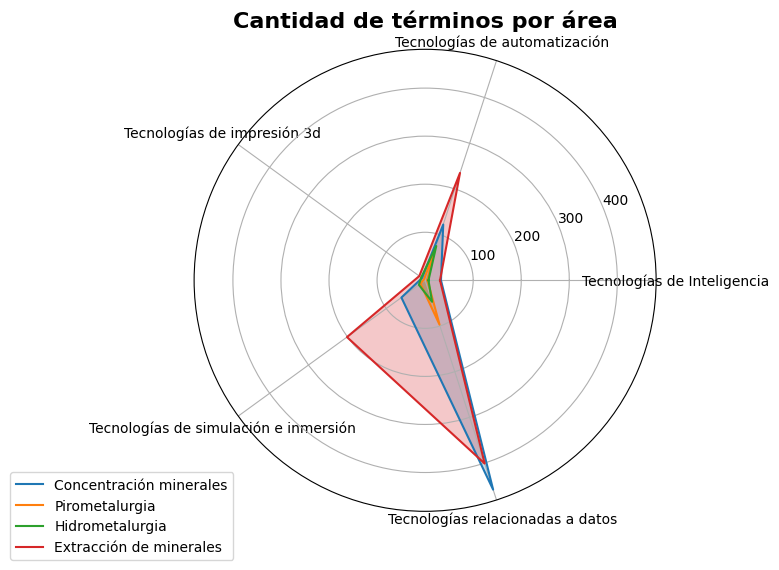

In [46]:
# Número de categorías
labels = df.index
num_vars = len(labels)

# Angulos para el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
angles += angles[:1]

# Preparar la figura
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Dibujar cada una de las áreas
for area in df.columns:
    values = df[area].tolist()
    values += values[:1]  # Completar el círculo

    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, label=area)

# Agregar etiquetas
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar gráfico
plt.title("Cantidad de términos por área", fontsize=16, fontweight="bold")
plt.show()

### Radar con frecuencia relativa

In [47]:
# Organizar los datos en un diccionario
areas = defaultdict(dict)

for categoria, area, total in frecuencias:
    areas[area][categoria] = total

# Convertir el diccionario en un DataFrame para facilidad de uso
df = pd.DataFrame(areas).fillna(0)

# Calcular los porcentajes
df_percentage = df.div(df.sum(axis=0), axis=1) * 100

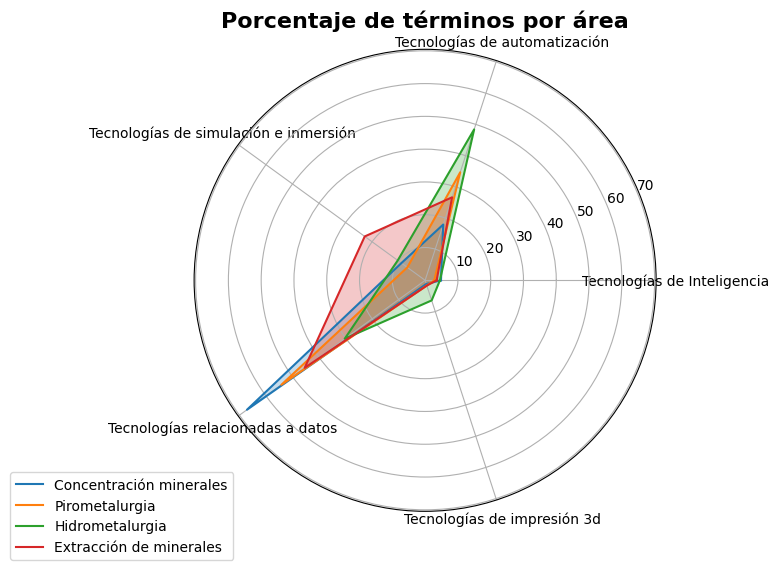

In [48]:
# Número de categorías
labels = df_percentage.index
num_vars = len(labels)

# Angulos para el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Completar el círculo

# Preparar la figura
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Dibujar cada una de las áreas con porcentajes
for area in df_percentage.columns:
    values = df_percentage[area].tolist()
    values += values[:1]  # Completar el círculo

    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, label=area)

# Agregar etiquetas
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Añadir leyenda
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Mostrar gráfico
plt.title("Porcentaje de términos por área", fontsize=16, fontweight="bold")
plt.show()


### Mapa de calor

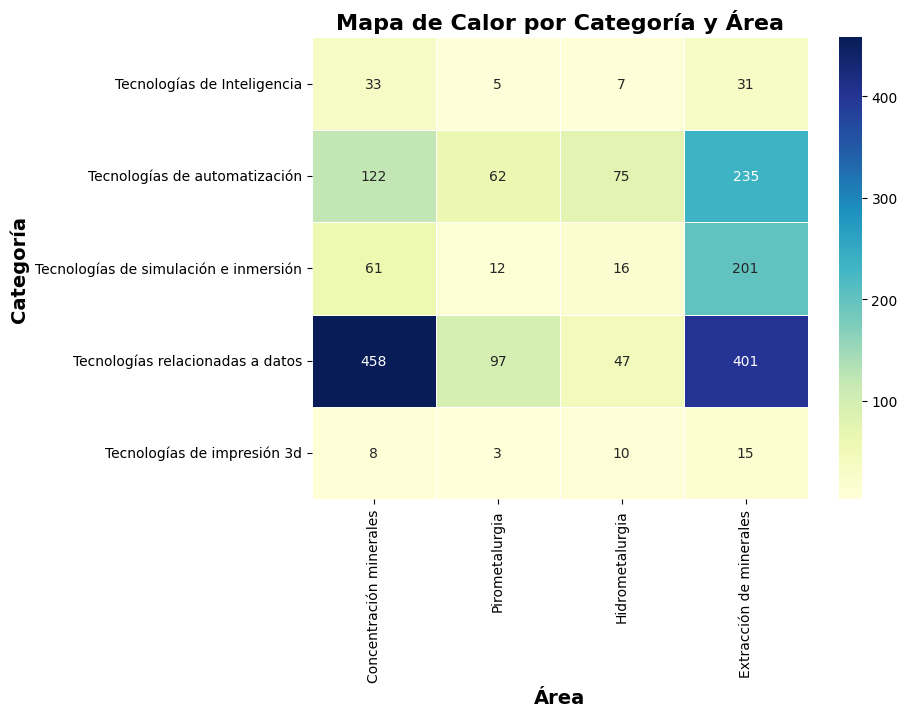

In [49]:
# Crear el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", linewidths=.5, fmt=".0f")

# Añadir título y etiquetas
plt.title('Mapa de Calor por Categoría y Área', fontsize=16, fontweight="bold")
plt.xlabel('Área', fontsize=14, fontweight="bold")
plt.ylabel('Categoría', fontsize=14, fontweight="bold")

# Mostrar el gráfico
plt.show()


### Gráfico de barras

In [50]:
data_resumen_limpia.columns

Index(['title', 'abstract', 'publication_date', 'publication_year',
       'applicants', 'area', 'tokens'],
      dtype='object')

In [51]:
data_resumen_limpia.publication_year.unique()

array([2020, 2023, 2024, 2022, 2021])

In [52]:
data_resumen_limpia.area.unique()

array(['Concentración minerales', 'Pirometalurgia', 'Hidrometalurgia',
       'Extracción de minerales'], dtype=object)

In [53]:
def obtiene_frecuencias_por_area(data_source : pd.DataFrame, lst_categorias : np.array,
                                 target_area : str, inicio : int, fin : int):
  data_frecuencia = get_all_frequency(data=data_source,
                                    categorias=lst_categorias,
                                    area = target_area,
                                    inicio = inicio, final = fin)
  return data_frecuencia

In [29]:
def grafico_barras_etiquetas(data_frecuencia : pd.DataFrame, target_area : str):
  # Transformar el DataFrame a formato largo
  df_long = pd.melt(data_frecuencia, id_vars=['categoria'], var_name='Año', value_name='Frecuencia')

  # Gráfico de barras agrupadas
  plt.figure(figsize=(12, 6))
  ax = sns.barplot(data=df_long, x='Año', y='Frecuencia', hue='categoria')
  # Añadir etiquetas con las frecuencias sobre las barras
  for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
  # Personalizar el gráfico
  plt.title(f'Evolución de las Frecuencias de términos 4.0\n{target_area}\n({inicio}-{fin})', fontsize=18, fontweight="bold")
  plt.xlabel('Año', fontsize=16, fontweight="bold")
  plt.ylabel('Frecuencia', fontsize=16, fontweight="bold")
  plt.legend(title='Categoría', loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
  plt.show()

In [30]:
# Obtiene el año de inicio y de término según lo indica la data
x_area = 'Pirometalurgia'
inicio, fin = np.min(data_resumen_limpia['publication_year']), np.max(data_resumen_limpia['publication_year'])
#data_frecuencia = get_all_frequency(data=data_resumen_limpia,
                                    #categorias=datos["categorias"],
                                    #area = x_area,
                                    #inicio = inicio, final = fin)
data_frecuencia = obtiene_frecuencias_por_area(data_resumen_limpia, datos["categorias"],
                                               x_area, inicio, fin)
data_frecuencia

,categoria,2020,2021,2022,2023,2024
0,Tecnologías de Inteligencia,0,1,2,2,0
1,Tecnologías de automatización,12,17,13,12,8
2,Tecnologías de simulación e inmersión,3,4,2,2,1
3,Tecnologías relacionadas a datos,13,18,20,25,21
4,Tecnologías de impresión 3d,0,0,1,2,0


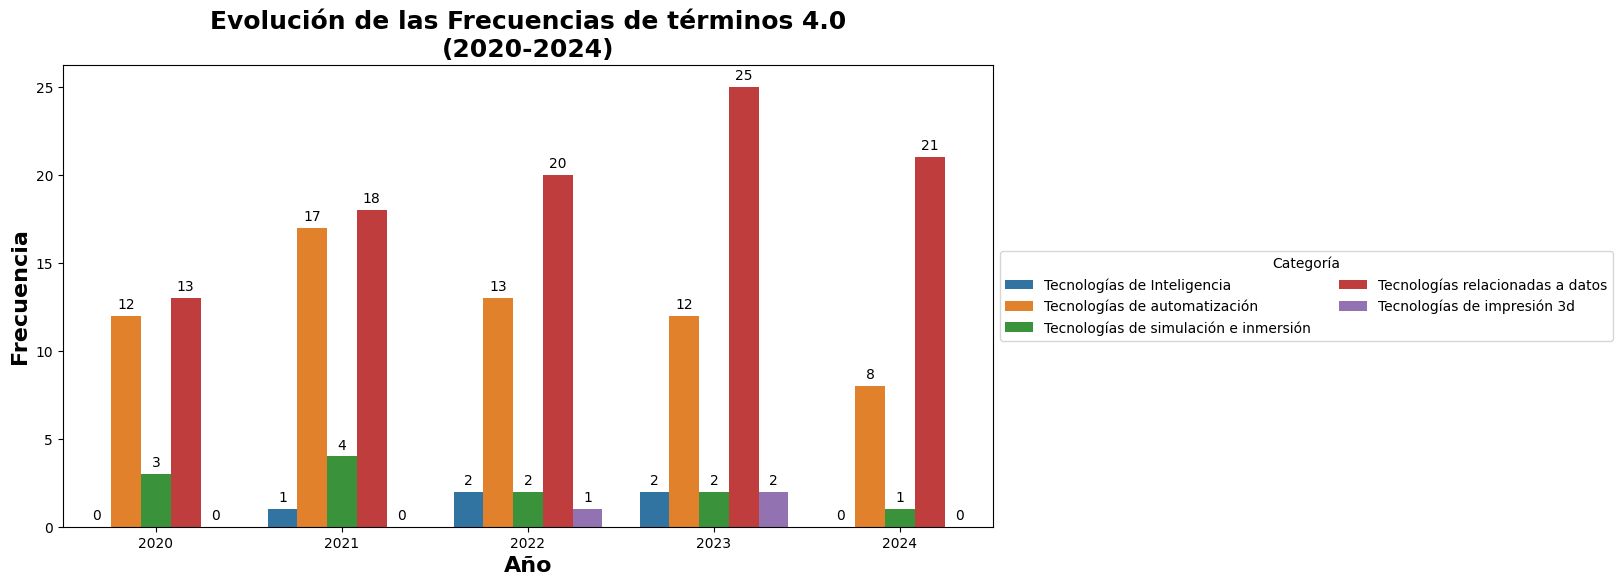

In [31]:
# Transformar el DataFrame a formato largo
df_long = pd.melt(data_frecuencia, id_vars=['categoria'], var_name='Año', value_name='Frecuencia')

# Gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_long, x='Año', y='Frecuencia', hue='categoria')
# Añadir etiquetas con las frecuencias sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
# Personalizar el gráfico
plt.title(f'Evolución de las Frecuencias de términos 4.0\n({inicio}-{fin})', fontsize=18, fontweight="bold")
plt.xlabel('Año', fontsize=16, fontweight="bold")
plt.ylabel('Frecuencia', fontsize=16, fontweight="bold")
plt.legend(title='Categoría', loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()


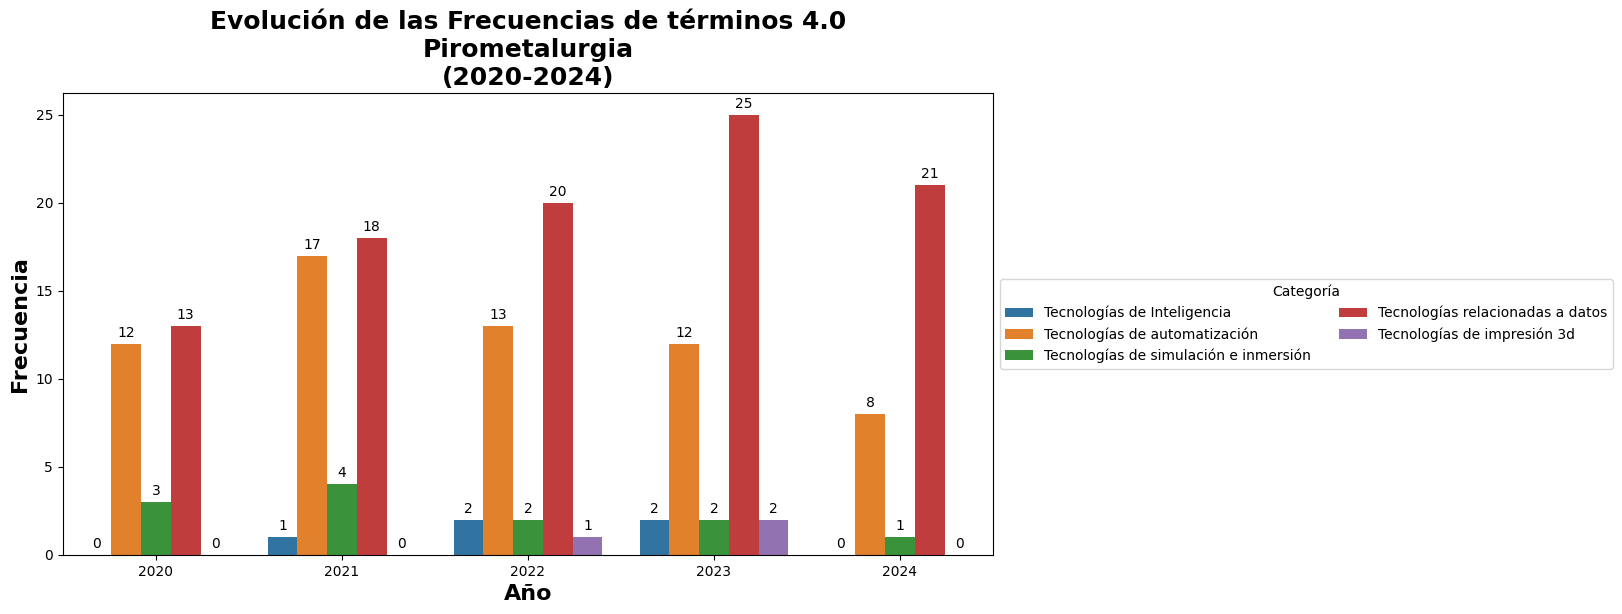

In [54]:
# Usando las funciones
# Obtiene el año de inicio y de término según lo indica la data
x_area = 'Pirometalurgia'
inicio, fin = np.min(data_resumen_limpia['publication_year']), np.max(data_resumen_limpia['publication_year'])
data_frecuencia = obtiene_frecuencias_por_area(data_resumen_limpia, datos["categorias"],
                                               x_area, inicio, fin)
grafico_barras_etiquetas(data_frecuencia, x_area)

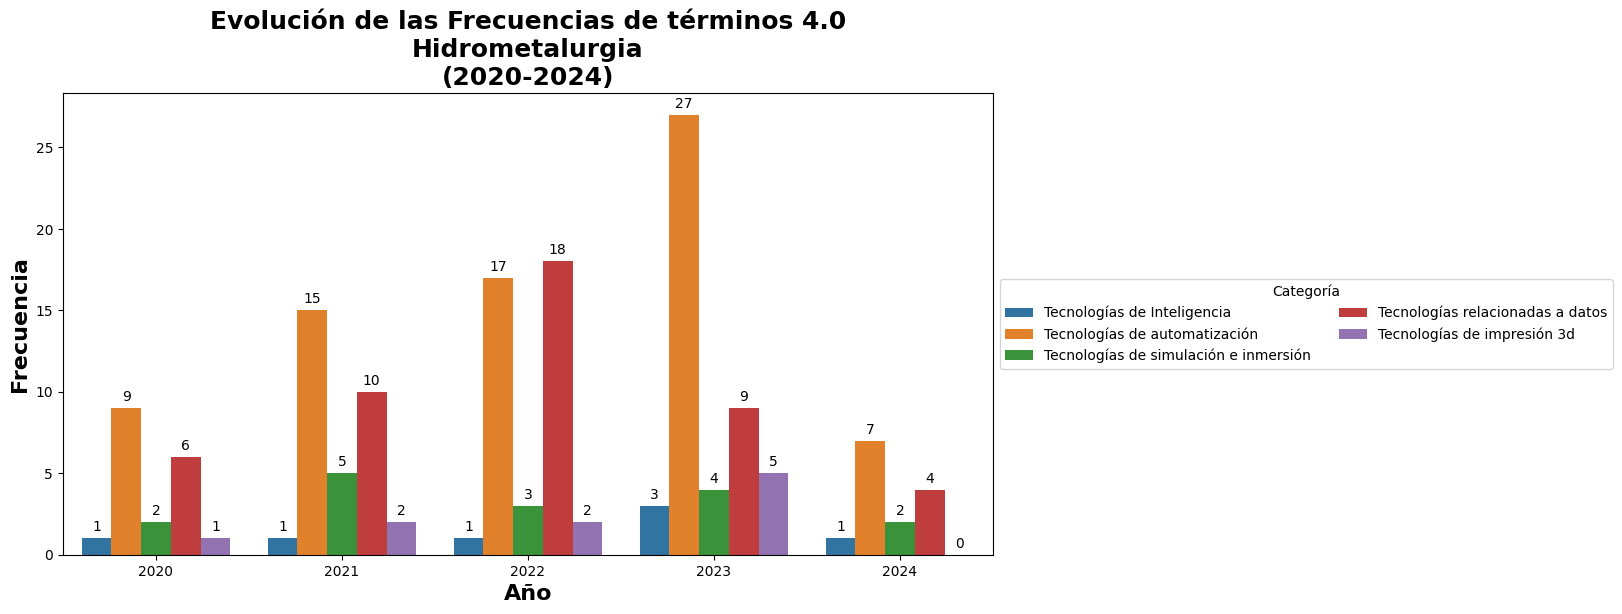

In [55]:
x_area = 'Hidrometalurgia'
inicio, fin = np.min(data_resumen_limpia['publication_year']), np.max(data_resumen_limpia['publication_year'])
data_frecuencia = obtiene_frecuencias_por_area(data_resumen_limpia, datos["categorias"],
                                               x_area, inicio, fin)
grafico_barras_etiquetas(data_frecuencia, x_area)

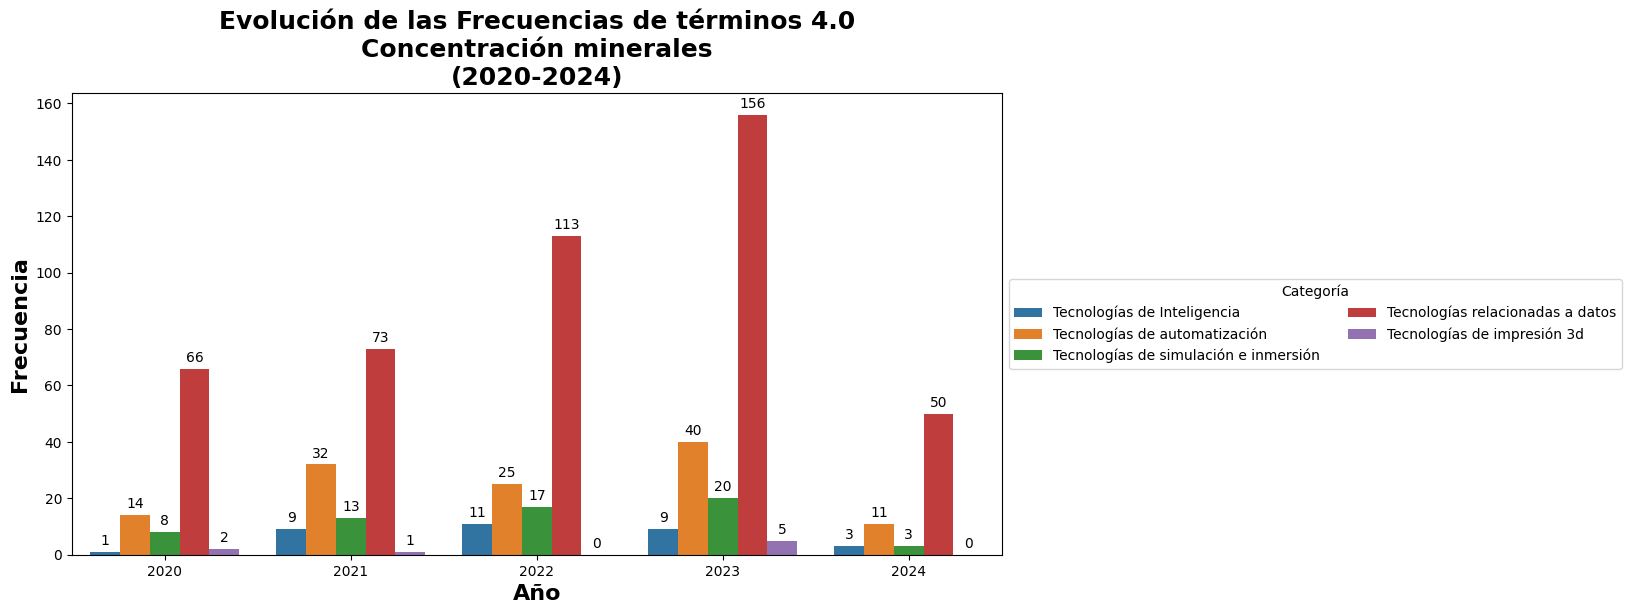

In [56]:
x_area = 'Concentración minerales'
inicio, fin = np.min(data_resumen_limpia['publication_year']), np.max(data_resumen_limpia['publication_year'])
data_frecuencia = obtiene_frecuencias_por_area(data_resumen_limpia, datos["categorias"],
                                               x_area, inicio, fin)
grafico_barras_etiquetas(data_frecuencia, x_area)

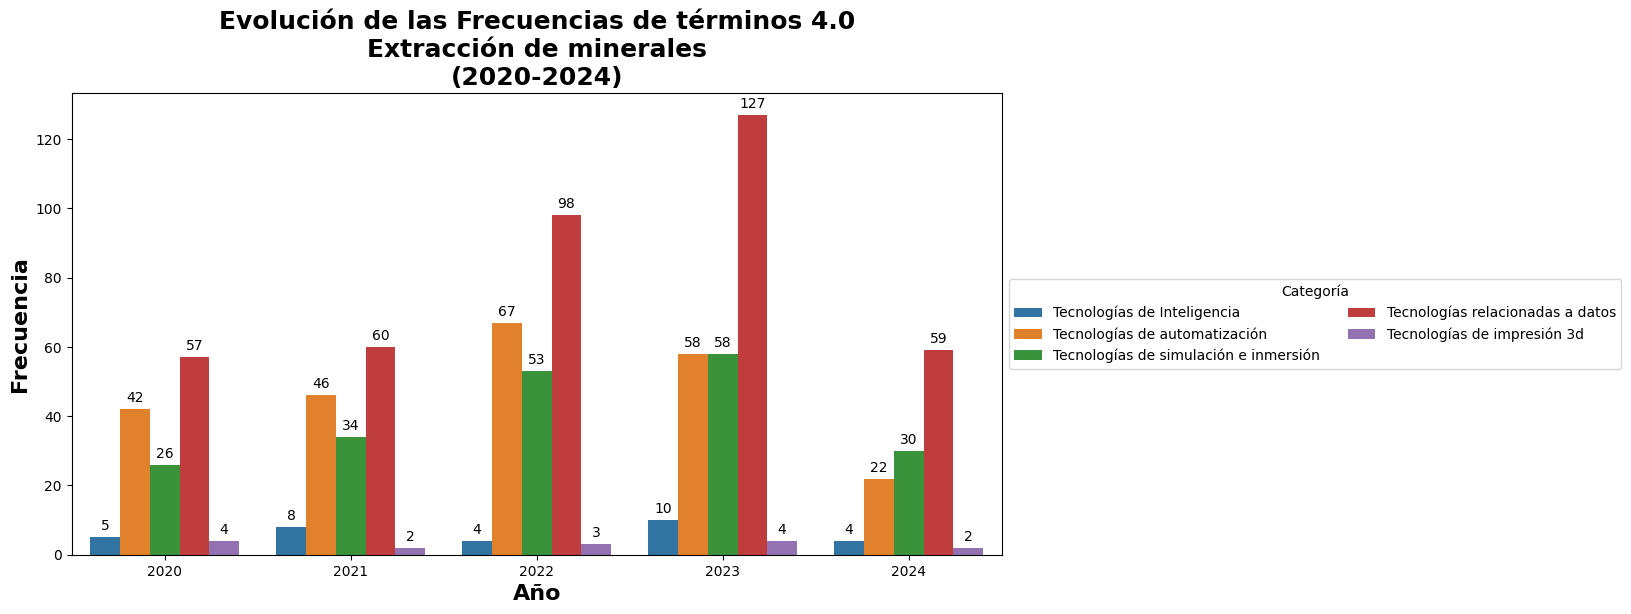

In [57]:
x_area = 'Extracción de minerales'
inicio, fin = np.min(data_resumen_limpia['publication_year']), np.max(data_resumen_limpia['publication_year'])
data_frecuencia = obtiene_frecuencias_por_area(data_resumen_limpia, datos["categorias"],
                                               x_area, inicio, fin)
grafico_barras_etiquetas(data_frecuencia, x_area)

# Análisis applicants

In [58]:
data_resumen_limpia.columns

Index(['title', 'abstract', 'publication_date', 'publication_year',
       'applicants', 'area', 'tokens'],
      dtype='object')

In [61]:
data_resumen_limpia.applicants.nunique()

5092

In [132]:
def aplicantes_mas_populares(data : pd.DataFrame, k : int):
  # Agrupam por 'area' y luego contamos la cantidad de patentes por 'applicants'
  top_applicants_by_area = data.groupby('area')['applicants'].value_counts().reset_index(name='total')

  # Para obtener los top 10 de cada área
  top_k_applicants_by_area = top_applicants_by_area.groupby('area').apply(lambda x: x.nlargest(k, 'total')).reset_index(drop=True)

  return top_k_applicants_by_area

def filtro_por_area(data : pd.DataFrame, target_area : str):
  #return data.query(f"area == '{target_area}'")[['applicants', 'total']]
  return data[data['area'].str.lower() == target_area.lower()][['applicants', 'total']]

def applicants_con_mas_areas(data: pd.DataFrame, min_areas: int = 2):
    """
    Retorna los aplicantes que están asociados a más de una cierta cantidad de áreas.

    Parámetros:
    - data (pd.DataFrame): DataFrame que contiene la información de los aplicantes.
    - min_areas (int): Cantidad mínima de áreas que debe tener un aplicante.

    Retorna:
    - pd.DataFrame: DataFrame con los aplicantes que tienen más de 'min_areas' áreas.
    """
    # Contar el número de áreas únicas asociadas a cada "applicant"
    applicant_area_counts = data.groupby('applicants')['area'].nunique().reset_index()

    # Renombrar la columna para mayor claridad
    applicant_area_counts.columns = ['applicants', 'num_areas']

    # Filtrar los aplicantes que tengan más de 'min_areas' áreas
    applicant_area_counts = applicant_area_counts[applicant_area_counts['num_areas'] > min_areas]

    # Ordenar los resultados por número de áreas de forma descendente
    applicant_area_counts = applicant_area_counts.sort_values(by='num_areas', ascending=False)

    return applicant_area_counts

def areas_por_aplicante(data: pd.DataFrame, target_applicant: str):
  # Filtrar filas donde el nombre del applicant contenga target_applicant sin distinguir mayúsculas/minúsculas
  areas = data[data['applicants'].str.contains(target_applicant, case=False, na=False)]['area']

  # Obtener las áreas únicas y retornarlas como una lista
  return areas.unique().tolist()

## Obtiene los K principales aplicantes por área

In [72]:
top_applicants = aplicantes_mas_populares(data_resumen_limpia, 10)

## Obtiene los nombres de los K principales aplicantes dada un área

In [106]:
# Considerando el resultado anterior
filtro_por_area(top_applicants, 'ConceNtración minerales')

,applicants,total
0,UNIV CENTRAL SOUTH,22
1,UNIV KUNMING SCIENCE & TECHNOLOGY,20
2,PING AN LIFE INSURANCE CO CHINA LTD,16
3,EPIROC ROCK DRILLS AB,16
4,UNIV NORTHEASTERN,14
5,UNIV SHANDONG SCIENCE & TECH,13
6,ANSTEEL GROUP MINING IND CO LTD,12
7,CHINA CONSTRUCTION BANK CORP;;CCB FINTECH CO LTD,11
8,FANKOU LEAD ZINC MINE SHENZHEN ZHONGJIN LINGNA...,11
9,FREEPORT MINERALS CORP,11


In [74]:
filtro_por_area(top_applicants, 'Extracción de minerales')

,applicants,total
10,UNIV LIAONING TECHNICAL,38
11,UNIV CHINA MINING & TECH,37
12,UNIV CENTRAL SOUTH,37
13,UNIV SHANDONG SCIENCE & TECH,37
14,UNIV CHINA MINING,35
15,UNIV NORTHEASTERN,35
16,ANSTEEL GROUP MINING IND CO LTD,34
17,UNIV ANHUI SCI & TECHNOLOGY,34
18,BEIJING RES INST URANIUM GEOLOGY,33
19,SANDVIK MINING & CONSTRUCTION OY,25


## Obtiene las áreas de en las que ha participado un determinado aplicante

In [121]:
areas_por_aplicante(data_resumen_limpia, 'UNIV BEIHANG')

['Concentración minerales',
 'Pirometalurgia',
 'Hidrometalurgia',
 'Extracción de minerales']

In [122]:
areas_por_aplicante(data_resumen_limpia, '주식회사 잼픽')

['Concentración minerales', 'Hidrometalurgia']

In [123]:
areas_por_aplicante(data_resumen_limpia, 'FREEPORT MINERALS CORP')

['Concentración minerales',
 'Pirometalurgia',
 'Hidrometalurgia',
 'Extracción de minerales']

## Obtiene los aplicantes que tienen presencia en más áreas que las que indica el filtro

In [131]:
# Obtiene los aplicantes que tienen presencia en 3 o más áreas
applicants_con_mas_areas(data_resumen_limpia, 3)

,applicants,num_areas
120,ANHUI LUJIANG LONGQIAO MINING CO LTD,4
4268,UNIV NANJING INFORMATION SCIENCE & TECH,4
4062,UNIV CENTRAL SOUTH,4
4080,UNIV CHENGDU TECHNOLOGY,4
4087,UNIV CHINA GEOSCIENCES BEIJING,4
...,...,...
2728,OFF WORLD INC,4
3009,SANYHE INTERNAT HOLDINGS CO,4
3251,SHANGHAI FENGSHI TECH CO LTD,4
3402,SHENYANG INST AUTOMATION CAS,4




---


@author - Jazna Meza Hidalgo

@version - 2024